A concrete beam with a span of L=6.75 m is considered, simply supported and subjected to the following uniformly distributed loads:
- Self weight: $q_{sw}$=12.2 kN/m
- Dead load: $q_{dl}$=5.2 kN/m
- Live load: $q_{ll}$=11.7 kN/m
It is considered that 30% of the live load is quasi-permanent (ψ2=0.3)

![beam](EX1&2Beam.png)

The section, 0.35 m wide and 0.50 m height, is reinforced with 6φ20 on the lower face and 3φ12 on the upper face. For calculation purposes, the cover is 5 cm. The concrete is class C25/30. The structure is located 2 km from the coast in
the open. A creep coefficient of 2.5 will be considered.

It is requested:
1. Determine the characteristic crack opening in the critical section.
2. Evaluate the admissibility of the crack opening applying EN 1992-1-1.

In [1]:
from structuralcodes.codes.ec2_2004 import __materials__
from structuralcodes.codes.ec2_2004 import _section_7_3_crack_control
from structuralcodes.materials.concrete import ConcreteEC2_2004,ConcreteEC2_2023
from structuralcodes.materials.reinforcement import ReinforcementEC2_2023, ReinforcementEC2_2004
from shapely import Polygon
from structuralcodes.geometry import SurfaceGeometry,CompoundGeometry
from structuralcodes.sections._reinforcement import (
    add_reinforcement,
    add_reinforcement_line,
)
from structuralcodes.sections._generic import GenericSection
from structuralcodes.materials.constitutive_laws import Elastic, ElasticPlastic,ParabolaRectangle,UserDefined
from structuralcodes.plots.section_plots import draw_section
import math

Calculation of the inertia of the cracked cross-section in order to obtain $\sigma_s$

x (mm) from z=0: 219.4
I of cracked section (mm4):  3677810527


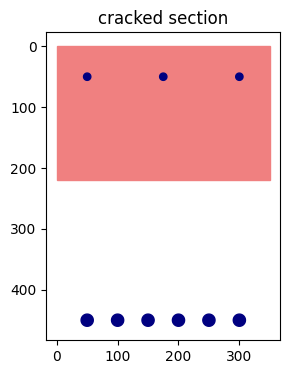

In [2]:
# Materials
fi =2.5
concrete = ConcreteEC2_2004(25)
Ec_eff=concrete.Ecm/(1+fi)
Ec = concrete.constitutive_law.get_tangent(0)[0]


# The package does not compute the Inertia of homogeneus cross secction, so a "concrete reinforfocement" with reinforcement areas multiplied by Es/Ec is used.
#reinforcemnet = ReinforcementEC2_2004(fyk=500, Es=200000, density=7850, ftk=550, epsuk=0.07)   
reinforcemnet = ReinforcementEC2_2004(fyk=500, Es=Ec, density=7850, ftk=550, epsuk=0.07)
n=200000/Ec_eff

# Create section
poly = Polygon(((0, 0), (350, 0), (350, 500), (0, 500)))
geo = SurfaceGeometry(poly, concrete)
geo = add_reinforcement_line(geo, (50, 50), (300, 50),12*math.sqrt(n), reinforcemnet, n=3)
geo = add_reinforcement_line(geo, (50, 450), (300, 450), 20*math.sqrt(n) , reinforcemnet, n=6)
sec = GenericSection(geo)

# Get the neutral axe of the cracked section
curv = 1e-7 # Curvature which produces elastic stresses in the most compressed fibre of the concrete section
eps =  sec.section_calculator.find_equilibrium_fixed_curvature(sec.geometry,0,curv,0)[0]
x=-eps/curv # Distance from z=0 to the neutral axe
print("x (mm) from z=0:",round(x,1))

# 2) Create the cracked section
poly2 = Polygon(((0, x), (350, x), (350, 0), (0, 0)))
geo2 = SurfaceGeometry(poly2, concrete)
geo2 = add_reinforcement_line(geo2, (50, 50), (300, 50),12*math.sqrt(n), reinforcemnet, n=3)
geo2 = add_reinforcement_line(geo2, (50, 450), (300, 450), 20*math.sqrt(n) , reinforcemnet, n=6)
sec2 = GenericSection(geo2)
Icr = sec2.gross_properties.i11
print("I of cracked section (mm4): ",round(Icr))
draw_section(sec2,"cracked section",math.sqrt(n))


Section 7.3.4. Calculation of crack widths

1.) Calculation of $\epsilon_{sm} - \epsilon_{cm}$:

In [3]:
long_beam = 6.75

# caracteriscic load
qk=12.2 + 5.2 + 11.7 # kN/m
# cuasipermant load
q_cuasip=12.2 + 5.2 + 11.7 * 0.3 # kN/m

fi = 2.5

# Mcuasip at midspan
m_cuasip = q_cuasip * long_beam**2/8

# Create section to get hc_eff
concrete = ConcreteEC2_2004(25)
reinforcemnet = ReinforcementEC2_2004(fyk=500, Es=200000, density=7850, ftk=550, epsuk=0.07)  
poly = Polygon(((0, 0), (350, 0), (350, 500), (0, 500)))
geo = SurfaceGeometry(poly, concrete)
geo = add_reinforcement_line(geo, (50, 50), (300, 50),12, reinforcemnet, n=3)
geo = add_reinforcement_line(geo, (50, 450), (300, 450), 20, reinforcemnet, n=6)
sec = GenericSection(geo)
hc_eff = _section_7_3_crack_control.hc_eff(500,450,500-sec.gross_properties.cz)

Ec_eff = concrete.Ecm/(1+fi)
alfa_e = _section_7_3_crack_control.alpha_e(200000,Ec_eff)
rho_p = _section_7_3_crack_control.rho_p_eff(6* math.pi*100, 0 ,0,hc_eff*350)  # b=350mm, fi=20mm
kt = _section_7_3_crack_control.kt('long')
fct_eff = concrete.fctm
sigma_s = (n * m_cuasip / (Icr/1000**4) * (450-x)/1000) / 1000 # MPa
eps_sm_eps_cm =_section_7_3_crack_control.eps_sm_eps_cm(sigma_s,alfa_e,rho_p,kt,fct_eff,200000)
print('eps_sm_eps_cm =',round(eps_sm_eps_cm, 5))
print(' alfa_e =',round(alfa_e,3))
print(' hc_eff (mm) =',round(hc_eff))
print(' rho_p =',round(rho_p,5))
print(' kt =',kt)
print(' sigma_s (MPa) =',round(sigma_s))
print(' fct_eff (MPa) =',round(fct_eff,2))



eps_sm_eps_cm = 0.00063
 alfa_e = 22.239
 hc_eff (mm) = 89
 rho_p = 0.0602
 kt = 0.4
 sigma_s (MPa) = 166
 fct_eff (MPa) = 2.56


2.) Crack spacing $S_{r,max}$:

In [4]:
# crack spacing
k1 =_section_7_3_crack_control.k1(bond_type='bond')
k2 =_section_7_3_crack_control.k2(0)
k3 =_section_7_3_crack_control.k3()
k4 =_section_7_3_crack_control.k4()
c=50-20/2
fi_rebars=20
sr_max = _section_7_3_crack_control.sr_max_close(c,fi_rebars,rho_p,k1,k2,k3,k4)
print('sr_max (mm)',round(sr_max))
print(' c (mm)',c)
print(' fi (mm)',fi_rebars)
print(' k1',k1)
print(' k2',k2)
print(' k3',k3)
print(' k4',k4)



sr_max (mm) 192
 c (mm) 40.0
 fi (mm) 20
 k1 0.8
 k2 0.5
 k3 3.4
 k4 0.425


3) Crack width $w_k$

In [5]:
wk = _section_7_3_crack_control.wk(sr_max,eps_sm_eps_cm)
print('wk (mm)',round(wk,2))
wmax = _section_7_3_crack_control.w_max('XS1','qp')
print('wmax (mm)',wmax)

wk (mm) 0.12
wmax (mm) 0.3
